Brandon Punturo
NBA Draft Exploratory Analysis

# Skills Shown
> <font color='red'> Web Scraping </font> <br>
> <font color='blue'>  Data Visualization </font> <br>
> <font color='green'> Regression </font> <br>

## Introduction:
### The NBA is one of the most popular professional sport leagues in the world. In recent years, the league has seen an uptick in popularity on the global scale. This is has led to an influx of international stars. However, the majority of the league’s players still come from teams in the NCAA. Unlike professional football, basketball players in the NCAA can choose to leave for the pros after their freshman year. This “One and Done” rule became official in 2006 after the NBA made it illegal for players to jump to the pros out of high school. However, are the players who leave early (before their senior year) better in the NBA than those who stay all four years? That is what I set out to determine for my final project.

In [45]:
#Importing the necessary Libraries
import pandas as pd
import numpy as np
import seaborn as sns
from urllib.request import urlopen
from bs4 import BeautifulSoup
import statsmodels.formula.api as smf
import string
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

## Part 1:
### Scraping and Cleaning. 
## Sources:
I had four sources of data for this project: Kaggle, Sports Reference, Landofbasketball
and Wikipedia. They all served different purposes. From Wikipedia I sourced the 2006-2013
NBA Drafts(For example: https://en.wikipedia.org/wiki/2013_NBA_draft). I started with the
2006 draft because that was the first year the NBA made it illegal for players to come straight out
of high school. I ended with 2013, because, in my opinion, it is unfair to judge a player until he
has had at least 5 years in the league. The most important variables were “Player”, and the
“School/Club Team” variables.
From Kaggle, I sourced a csv file containing NBA statistics(downloaded from:
https://www.kaggle.com/drgilermo/nba-players-stats/data). Every row contained a player’s
statistics from that year. However, it contained totals instead of per game statistics. It contained
data from 1950 to present. The most important variables were “G”(games played), “Points”
,”Rebounds” and “Assists”.
From sports reference, I scraped two types of tables. The first was a table containing each
player’s college statistics(https://www.sports-reference.com/cbb/players/). I had to individually
scrape a table for each player. The most important variables were “PTS”, “TRB” and “AST.”
The other type was a table containing the number of all-star appearances each player
had(https://www.basketball-reference.com/awards/all_star_by_player.html). The most important
variable here was “NBA” which stood for number of NBA All-Star games made.
The final source I used was a website called
Landofbasketball("http://www.landofbasketball.com/awards/all_nba_teams_player_total.htm"). I
scraped a table containing the number of All-NBA appearances every player has had. 

In [4]:
#Reading in the season stats file
nba_season_stats=pd.read_csv("Seasons_Stats.csv")

In [5]:
#Condensing data frame down to columns I am interested in
nba_season_statss=nba_season_stats[["Player","Year","G","MP","WS","PTS","PER","TRB","AST"]]

In [6]:
#Filtering to players drafted from 2006 til present
nba_season_statss=nba_season_statss[nba_season_statss.Year>=2006]
amount_of_years=nba_season_statss.groupby("Player")[["Year"]].count()

In [7]:
#Manipulating data creating columns for averages across seasons
#Condensing Each Player into one column
nba_season_statss=nba_season_statss.groupby(nba_season_statss.Player, axis=0).sum()
nba_season_statss["Player"]=nba_season_statss.index
nba_season_statss["Points_Per_Game"]=nba_season_statss["PTS"]/nba_season_statss["G"]
nba_season_statss["Rebounds_Per_Game"]=nba_season_statss["TRB"]/nba_season_statss["G"]
nba_season_statss["Assists_Per_Game"]=nba_season_statss["AST"]/nba_season_statss["G"]
nba_season_statss["Career_PER"]=nba_season_statss.apply(lambda x: x["PER"]/amount_of_years.loc[x["Player"]].Year,axis=1)
nba_season_statss=nba_season_statss.drop(columns=["Year","MP","TRB","AST","PTS"])

In [8]:
# Scraping Draft Data from Wikipedia
i=2006
wikipedia_draft=[]
while i <2014:
    z=pd.read_html("https://en.wikipedia.org/wiki/{}_NBA_draft".format(i),header=0)
    z[3]["year"]=i
    wikipedia_draft.append(z[3])
    i+=1


In [10]:
#name_shortener condenses name column
#For loop is cleaning up the name column by removing unnecessary stuff
#Creating a column that indicates what year player left college
for draft in wikipedia_draft:
    draft.Player=draft.Player.str.replace("~","")
    draft.Player=draft.Player.str.replace("^","")
    draft.Player=draft.Player.str.replace("*","")
    draft.Player=draft.Player.str.replace("+","")
    draft.Player=draft.Player.str.replace("x","")
    draft.Player=draft.Player.str.replace("#","")
    draft["College_Year"]=draft.iloc[:,6].str.extract("\(([\w.]+)\)")


/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:11: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  # This is added back by InteractiveShellApp.init_path()


In [11]:
#Now that the data is cleaned up, creating a dataframe to have all draft records in one area
all_drafts=pd.DataFrame()
for draft in wikipedia_draft:
    all_drafts=pd.concat([draft,all_drafts],ignore_index=True)

In [13]:
#Merging wikipedia draft data with Player statistics on "Player" Column
draft_nbastats_df=all_drafts.merge(nba_season_statss,on="Player")
draft_nbastats_df=draft_nbastats_df.rename(columns={"Nationality[n 1]":"Nationality"})

In [14]:
draft_nbastats_df.head()

,College_Year,Nationality,Pick,Player,Pos.,Position,Rnd.,Round,School / club team,School/club team,Team,year,G,WS,PER,Points_Per_Game,Rebounds_Per_Game,Assists_Per_Game,Career_PER
0,Fr.,Canada,1,Anthony Bennett,PF/SF,NaN,1.0,NaN,UNLV (Fr.),NaN,Cleveland Cavaliers,2013,151.0,0.5,43.4,4.357616,3.125828,0.509934,10.85
1,Jr.,United States,2,Victor Oladipo,SG/PG,NaN,1.0,NaN,Indiana (Jr.),NaN,Orlando Magic,2013,291.0,13.7,59.8,15.869416,4.353952,3.711340,14.95
2,So.,United States,3,Otto Porter,SF,NaN,1.0,NaN,Georgetown (So.),NaN,Washington Wizards,2013,266.0,17.7,49.4,9.281955,4.451128,1.187970,12.35
3,So.,United States,4,Cody Zeller,C/PF,NaN,1.0,NaN,Indiana (So.),NaN,Charlotte Bobcats,2013,279.0,18.3,60.0,8.025090,5.645161,1.297491,15.00
4,Fr.,United States,6,Nerlens Noel,C,NaN,1.0,NaN,Kentucky (Fr.),NaN,New Orleans Pelicans (traded to Philadelphia)[A],2013,244.0,15.0,92.3,9.758197,7.135246,1.434426,18.46


In [15]:
#Filtering Data to get rid of players drafted out of US Colleges
draft_nbastats_df=draft_nbastats_df[(draft_nbastats_df.College_Year == "So.")|(draft_nbastats_df.College_Year == "Fr.")|(draft_nbastats_df.College_Year == "Sr.")|(draft_nbastats_df.College_Year == "Jr.")]

In [16]:
#Scraping College Statistics for all players in the dataset from sports-reference
#Will take around 5 minutes to run
college_career_stats=[]
for player in draft_nbastats_df.Player.values:
    try:
        player_l=player.lower()
        exclude = set(string.punctuation)
        exclude.remove("-")
        player_l = ''.join(ch for ch in player_l if ch not in exclude)
        url='https://www.sports-reference.com/cbb/players/{0}-{1}-1.html'.format( \
            player_l.split(" ")[0],player_l.split(" ")[1])
        read=pd.read_html(url)
        df=read[0][read[0].Season=="Career"]
        df["Player"]=player
        college_career_stats.append(df)
    except:
        "{} not on the website".format(player)

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


In [17]:
# Condensing all of this data to a dataframe
college_stats=pd.DataFrame()

for stats in college_career_stats:
    college_stats=pd.concat([stats,college_stats],ignore_index=True)
college_stats=college_stats.dropna(axis=1)

In [18]:
#Renaming columns to include _college at the end
for column in list(college_stats):
    if column== "Player":
        "Next"
    else:
        college_stats=college_stats.rename(columns={column: column+"_college"})
college_stats=college_stats[["AST_college","PTS_college","Player","TRB_college"]]

# Part II:  Analysis and Data Viz

The first thing I wanted to check was the distribution of picks among the different college
years. In other words, what college year gets drafted earliest on average? To analyze this, I split
the draft data into three subgroups: lottery, first round and second round. The lottery is the first
14 picks in the draft, the first round is the first 30 picks, and the second round is picks 31-60. The
results I found were shocking, to say the least. Seniors are by far the most likely group to be
drafted in the second round, while freshman are the most likely group to be drafted in the first
14 picks. To visualize the distribution of picks by college year, I created a violin plot. The
thicker part of each plot indicates that most players from that college year are drafted around that
range of picks.

In [19]:
#Lottery defined as the first 14 picks in the Draft
#Using groupby to count how many players were drafted in this range from each college year
Lottery=draft_nbastats_df[(draft_nbastats_df.Round==1) & (draft_nbastats_df.Pick>=1) & (draft_nbastats_df.Pick <=14)]
Lottery.groupby("College_Year")[["Pick"]].count()

,Pick
College_Year,
Fr.,28
Jr.,24
So.,22
Sr.,10


In [20]:
#First Round is defined as the first thirty picks in the NBA draft (includes Lottery)
#Using groupby to count how many players were drafted in this range from each college year
First_round=draft_nbastats_df[(draft_nbastats_df.Round==1) & (draft_nbastats_df.Pick>=1) & (draft_nbastats_df.Pick <=30)]
First_round.groupby("College_Year")[["Pick"]].count()

,Pick
College_Year,
Fr.,42
Jr.,47
So.,44
Sr.,36


In [21]:
#Second Round is defined as Picks thirty one to sixty.
#Using groupby to count how many players were drafted in this range from each college year
Second_round=draft_nbastats_df[(draft_nbastats_df.Round==2) & (draft_nbastats_df.Pick>=31) & (draft_nbastats_df.Pick <=60)]
Second_round.groupby("College_Year")[["Pick"]].count()

,Pick
College_Year,
Fr.,5
Jr.,30
So.,14
Sr.,70


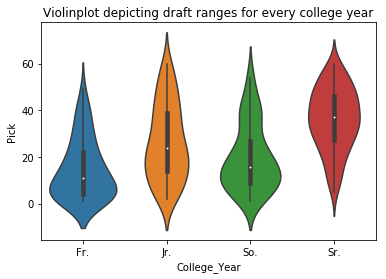

In [22]:
#Creating a violin plot to depict that draft ranges for players
sns.violinplot(x="College_Year",y="Pick",data=draft_nbastats_df).set_title("Violinplot \
depicting draft ranges for every college year")

## Analysis and Data Viz-Continued 
The second way I wanted to analyze success was NBA averages. To accomplish this, I first merged the NBA
statistics dataset with the draft dataset. I then masked the dataset into four DataFrames
corresponding to each college year. I then used the .describe() method in Pandas, and used the
.loc method to access the mean for average pick drafted at, points per game, rebounds per game,
assists per game and total games played. Again, I found that players who left after their freshman
year, on average, performed the best among all measures.

# Freshmen

In [23]:
#Computing average NBA stats for players drafted into the NBA as Freshmen
Freshman_stats=draft_nbastats_df[draft_nbastats_df["College_Year"]=="Fr."]
pd.DataFrame(Freshman_stats.describe().loc["mean"][["Pick","G","Points_Per_Game","Rebounds_Per_Game","Assists_Per_Game"]])

,mean
Pick,14.672727
G,386.163636
Points_Per_Game,10.815193
Rebounds_Per_Game,4.637038
Assists_Per_Game,2.050733


# Sophomores

In [24]:
#Computing average NBA stats for players drafted into the NBA as Sophomores
Soph_stats=draft_nbastats_df[draft_nbastats_df["College_Year"]=="So."]
pd.DataFrame(Soph_stats.describe().loc["mean"][["Pick","G","Points_Per_Game","Rebounds_Per_Game","Assists_Per_Game"]])

,mean
Pick,19.843750
G,372.750000
Points_Per_Game,9.053114
Rebounds_Per_Game,3.650831
Assists_Per_Game,2.034986


# Juniors

In [25]:
#Computing average NBA stats for players drafted into the NBA as Juniors
Jun_stats=draft_nbastats_df[draft_nbastats_df["College_Year"]=="Jr."]
pd.DataFrame(Jun_stats.describe().loc["mean"][["Pick","G","Points_Per_Game","Rebounds_Per_Game","Assists_Per_Game"]])

,mean
Pick,26.258824
G,346.858824
Points_Per_Game,7.181247
Rebounds_Per_Game,3.003378
Assists_Per_Game,1.556057


# Seniors

In [26]:
#Computing average NBA stats for players drafted into the NBA as Seniors
Senior_stats=draft_nbastats_df[draft_nbastats_df["College_Year"]=="Sr."]
pd.DataFrame(Senior_stats.describe().loc["mean"][["Pick","G","Points_Per_Game","Rebounds_Per_Game","Assists_Per_Game"]])

,mean
Pick,36.076271
G,239.847458
Points_Per_Game,5.033001
Rebounds_Per_Game,2.502391
Assists_Per_Game,0.999952


## Analysis and Data Viz Part 3
Once I scraped all the tables for college statistics, I created a column that added together
points, rebounds and assist averages for every player. I did the same thing for the NBA statistics
DataFrame. I merged the DataFrame mentioned in the paragraph above with the college statistics
one. Once I did this, I set out to see if I could create a simple linear regression model to see if the
points, rebound, assists totals in college could predict the points, rebound assist totals in the
NBA. My model was not that good (R^2 value of .13). However, after visualizing the data with seaborn, it does seem to be safe to say there does seem to be a positive linear relationship
between the two variables.

In [27]:
#Creating columns that add all assist, rebound and point averages. Will be used to assess total performance on each level
college_stats["PTS_RBS_AST_College"]=college_stats["AST_college"]+college_stats["PTS_college"]\
+college_stats["TRB_college"]
draft_nbastats_df["PTS_RBS_AST"]=draft_nbastats_df["Points_Per_Game"]+draft_nbastats_df["Rebounds_Per_Game"]\
+draft_nbastats_df["Assists_Per_Game"]

In [28]:
#Merging College and NBA Stats
merged_college_nba_stats=college_stats.merge(draft_nbastats_df, on ="Player")

In [29]:
#Isolating two columns
college_stats_total=merged_college_nba_stats[["Player","PTS_RBS_AST_College", "College_Year"]]
college_stats_total=college_stats_total.sort_values(by="PTS_RBS_AST_College",ascending=False)

In [30]:
#Isolating two columns
nba_stats_total=merged_college_nba_stats[["Player","PTS_RBS_AST", "College_Year"]]
nba_stats_total=nba_stats_total.sort_values(by="PTS_RBS_AST",ascending=False)

In [31]:
#Merging these two small dataframes
merged_totals=nba_stats_total.merge(college_stats_total,on="Player")

In [32]:
#Fitting a Linear Regression Model
model1 = smf.ols("PTS_RBS_AST~PTS_RBS_AST_College",data=merged_totals).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            PTS_RBS_AST   R-squared:                       0.138
Model:                            OLS   Adj. R-squared:                  0.135
Method:                 Least Squares   F-statistic:                     52.40
Date:                Sun, 08 Jul 2018   Prob (F-statistic):           3.24e-12
Time:                        14:51:38   Log-Likelihood:                -1118.1
No. Observations:                 330   AIC:                             2240.
Df Residuals:                     328   BIC:                             2248.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               1.5549      1.503      1.034      0.302      -1.402       4.512
PTS_RBS_AST_College     0.5171      0.071      7.238      0.000       0.377       0.658
==============================================================================
Omnibus:                       33.616   Durbin-Watson:                   0.297
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               40.865
Skew:                           0.811   Prob(JB):                     1.34e-09
Kurtosis:                       3.584   Cond. No.                         80.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

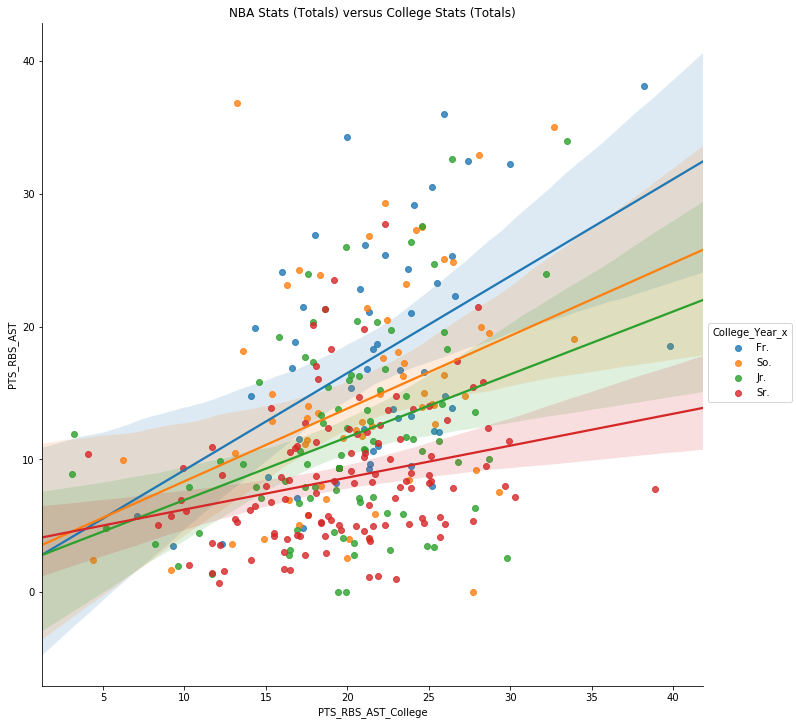

In [54]:
sns.lmplot(y="PTS_RBS_AST",x="PTS_RBS_AST_College",hue="College_Year_x",data=merged_totals,size=10)
ax = plt.gca()
ax.set_title("NBA Stats (Totals) versus College Stats (Totals)")

In [34]:
# Reading in all star selections from basketball refernece
all_stars=pd.read_html("https://www.basketball-reference.com/awards/all_star_by_player.html")

In [35]:
all_stars=all_stars[0].drop(columns={"ABA","Tot"})

In [36]:
#Merging all stars with current Players than writing to a .csv.
merged_all_stars=all_stars.merge(all_drafts,on="Player")
merged_all_stars.to_csv("All_stars.csv")

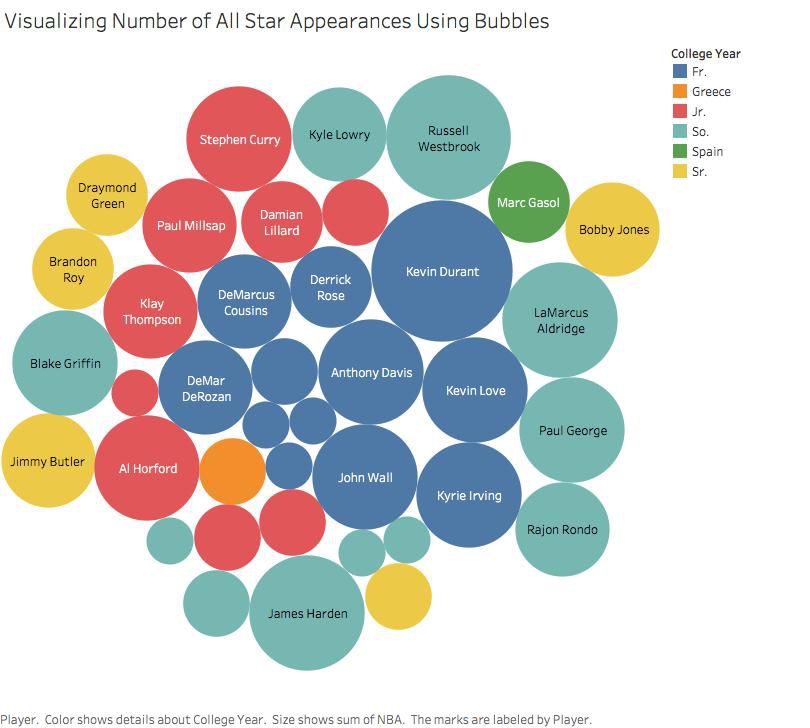

In [37]:
Image.open("Bubble_All_Stars.jpg")